# Logistic Regression (LR)

>> Model calibration ensures that the predicted probabilities faithfully represent the genuine likelihood of events, thereby enhancing the reliability of the model’s predictions.

>> Logistic regression typically outputs well-calibrated probability estimates.



>> Evaluation of model outcomes made easy: https://github.com/ploomber/sklearn-evaluation



>> scikit-learn’s CalibratedClassifierCV handles multi-class scenarios using a one-vs-rest approach.

> Overly complex models might overfit (overconfidence) leading to poorly calibrated predictions.

> Extreme regularization has an effect on predictions - over-regularization can cause underconfident predictions.

> Resampling to address class imbalance also has an effect on probability estimates.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
#print(dir(scipy))


from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score, brier_score_loss, log_loss
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

In [51]:
# create sample data and split into train and test subsets
X, y = datasets.make_classification(1000, 10, n_informative = 5, class_sep = 0.4, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [52]:
clf = LogisticRegression(random_state = 42)
clf.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [53]:
#predicted probabilities
probas = clf.predict_proba(X_test)
probas[:5]

array([[0.65129073, 0.34870927],
       [0.39916418, 0.60083582],
       [0.64836004, 0.35163996],
       [0.73150729, 0.26849271],
       [0.45986444, 0.54013556]])


>> Each row in the output represents the probability of belonging to class 0 (first column) or class 1 (second column)

>> We expect a model to give a higher probability when it’s more confident about specific prediction. For example, if the probability of belonging to class 1 is 0.6, we might assume the model isn’t as confident as with one example whose probability estimate is 0.95. This is a property exhibited by well-calibrated models.

>> However, models do not always exhibit this property, so we must ensure our model is well-calibrated if we want to prioritize predictions or make confident decisions based on the model output.

In [54]:
# probability belonging to the positive class
prob_positive = probas[:, 1]

# dataframe with probabilities and actual labels
df = pd.DataFrame({'prob': prob_positive, 'actual': y_test})

# binning the probabilities
df['prob_bin'] = pd.cut(df.prob, bins=np.arange(0, 1.1, 0.1))

df.head(5)

,prob,actual,prob_bin
0,0.348709,0,"(0.3, 0.4]"
1,0.600836,1,"(0.6, 0.7]"
2,0.351640,0,"(0.3, 0.4]"
3,0.268493,0,"(0.2, 0.3]"
4,0.540136,0,"(0.5, 0.6]"


In [55]:
df.groupby('prob_bin').actual.mean()

/tmp/ipython-input-1613762269.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('prob_bin').actual.mean()


,actual
prob_bin,
"(0.0, 0.1]",0.000000
"(0.1, 0.2]",0.000000
"(0.2, 0.3]",0.166667
"(0.3, 0.4]",0.288462
"(0.4, 0.5]",0.540000
"(0.5, 0.6]",0.509804
"(0.6, 0.7]",0.634146
"(0.7, 0.8]",0.866667
"(0.8, 0.9]",0.857143


>> We see that the model is reasonably calibrated. No sample belongs to the positive class for outputs between 0.0 and 0.1. Also, for the ones between 0.3 and 0.4, 29% belong to the positive class.


> It is hard to evaluate the numbers in a table; this is where a calibration curve helps, allowing us to assess calibration visually.

>> A perfectly calibrated model will output a score of 0.1 when it’s 10% confident that the model belongs to the positive class, 0.2 when it’s 20%, and so on. If we draw this, we’d have a straight line that is, ideally a well-calibrated model produces predicted probabilities that match the observed frequencies of the positive outcomes across different probability intervals.



# Uncalibrated LR

In [56]:
y_pred = clf.decision_function(X_test)
y_pred_proba = (y_pred - y_pred.min())/(y_pred.max() - y_pred.min())

>> https://scikit-learn.org/stable/modules/generated/sklearn.calibration.calibration_curve.html


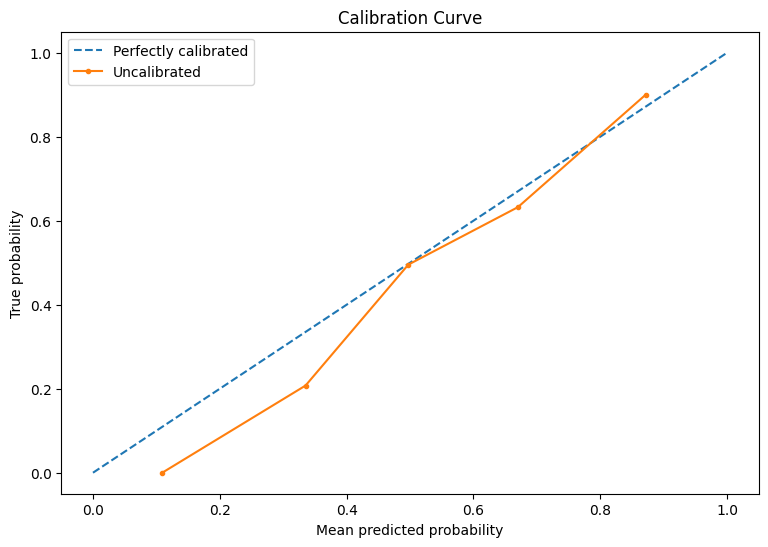

In [57]:
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba)  #default n_bins

# Calibration plot
plt.figure(figsize = (9, 6))
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfectly calibrated')
plt.plot(prob_pred, prob_true, marker = '.', label = 'Uncalibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('True probability')
plt.title('Calibration Curve')
plt.legend()
plt.show()

# Metrics

In [58]:
def compute_scores(y_true, y_pred_proba, name = None):

  scores = {
        'brier_score': brier_score_loss(y_true, y_pred_proba),
        'log_loss_score': log_loss(y_true, y_pred_proba),
        'roc_auc': roc_auc_score(y_true, y_pred_proba)}
  return pd.Series(scores).rename(name)

In [59]:
print(compute_scores(y_test, y_pred_proba, name = 'Uncalibrated'))

brier_score       0.212616
log_loss_score    0.745161
roc_auc           0.727331
Name: Uncalibrated, dtype: float64


# Calibration Methods

In [60]:
# Calibrate using Platt Scaling
clf_platt = CalibratedClassifierCV(clf, cv=5, method = 'sigmoid')
clf_platt.fit(X_train, y_train)

# Calibrate using Isotonic Regression
clf_isotonic = CalibratedClassifierCV(clf, cv=5, method = 'isotonic')
clf_isotonic.fit(X_train, y_train)

# Calibrated probability predictions
y_pred_proba_platt = clf_platt.predict_proba(X_test)[:, 1]
y_pred_proba_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]

In [63]:
prob_true, prob_pred_uncal = calibration_curve(
    y_test, y_pred_proba, n_bins = 5, strategy = 'quantile')  #quantile means equal-freq., #strategy => how the bins are created

prob_true_platt, prob_pred_platt = calibration_curve(
    y_test, y_pred_proba_platt, n_bins = 5, strategy = 'quantile')   #default n_bins

prob_true_isotonic, prob_pred_isotonic = calibration_curve(
    y_test, y_pred_proba_isotonic, n_bins = 5, strategy = 'quantile')

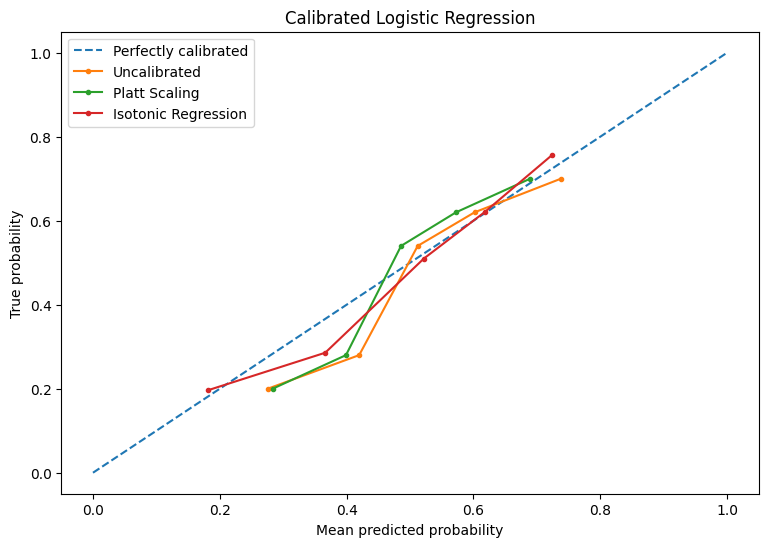

In [64]:
# Calibration plot

plt.figure(figsize = (9, 6))
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfectly calibrated')
plt.plot(prob_pred_uncal, prob_true, marker = '.', label = 'Uncalibrated')
plt.plot(prob_pred_platt, prob_true_platt, marker = '.', label = 'Platt Scaling')
plt.plot(prob_pred_isotonic, prob_true_isotonic, marker = '.', label = 'Isotonic Regression')
plt.xlabel('Mean predicted probability')
plt.ylabel('True probability')
plt.title('Calibrated Logistic Regression')
plt.legend()
plt.show()

In [71]:
# Compute metrics
df_scores = pd.DataFrame([
    compute_scores(y_test, y_pred_proba, name = 'Uncalibrated'),
    compute_scores(y_test, y_pred_proba_platt, name = 'Platt Scaling'),
    compute_scores(y_test, y_pred_proba_isotonic, name = 'Isotonic Regression')])
print(df_scores)

                     brier_score  log_loss_score   roc_auc
Uncalibrated            0.212616        0.745161  0.727331
Platt Scaling           0.212612        0.613829  0.727331
Isotonic Regression     0.208384        0.600682  0.729998


>> Platt Scaling recommended when the datasize is small, which is the case here.

> Probability calibration allows us to ensure that higher scores from trained model are more likely to belong to the positive class.